In [1]:
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import cv2, 
import random
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score,f1_score
import os
from tensorflow.keras import layers


In [2]:
np.random.seed(20)
ROWS = 150
COLS = 150
CHANNELS = 3

BATCH_SIZE=128


In [3]:
TRAIN_SCISSOR = []
TRAIN_ROCK = []
TRAIN_PAPER = []
TEST_IMAGES = []
Dir = './rock_paper_scissors/'
for i in os.listdir(Dir):
    for j in os.listdir(Dir+i):
        dir_image = f"{Dir}{i}/{j}"
        if i == 'scissors':
            TRAIN_SCISSOR.append(dir_image)
        elif i == 'rock':
            TRAIN_ROCK.append(dir_image)
        else:
            TRAIN_PAPER.append(dir_image)
print(len(TRAIN_PAPER) + len(TRAIN_ROCK)+len(TRAIN_SCISSOR))

2188


In [4]:
TEST_IMAGES = TRAIN_SCISSOR[int(len(TRAIN_SCISSOR)*0.8):] + TRAIN_ROCK[int(len(TRAIN_ROCK)*0.8):] + TRAIN_PAPER[int(len(TRAIN_PAPER)*0.8):]

In [5]:
len(TEST_IMAGES)

439

In [6]:
TRAIN_SCISSOR = TRAIN_SCISSOR[:int(len(TRAIN_SCISSOR)*0.8)]
TRAIN_ROCK = TRAIN_ROCK[:int(len(TRAIN_ROCK)*0.8)]
TRAIN_PAPER = TRAIN_PAPER[:int(len(TRAIN_PAPER)*0.8)]

In [7]:
print(len(TRAIN_PAPER) + len(TRAIN_ROCK)+len(TRAIN_SCISSOR) + len(TEST_IMAGES))

2188


In [8]:
TRAIN_IMAGES = TRAIN_PAPER+ TRAIN_ROCK + TRAIN_SCISSOR
random.shuffle(TRAIN_IMAGES)
random.shuffle(TEST_IMAGES)

In [9]:
len(TRAIN_IMAGES)
TRAIN_IMAGES[0]

'./rock_paper_scissors/scissors/vua0e2tJtebtNywx.png'

In [10]:
def plot_arr(arr):
    plt.figure()
    plt.imshow(image.array_to_img(arr))
    plt.show()

def plot(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [11]:
def prep_data(images):
    count = len(images)
    X = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((count,), dtype=np.float32)
    print("Starting")
    for i, image_file in enumerate(images):
        img = image.load_img(image_file, target_size=(ROWS, COLS))
        X[i] = image.img_to_array(img)
        if '/scissors/' in image_file:
            y[i] = 1.
        elif '/paper/' in image_file:
            y[i] = 2.
    
        i+=1
        if i == count:
            print('Processed {} of {}'.format(i, count))
        else:
            if i%1000 == 0: print('Processed {} of {}'.format(i, count))
        
    return X, y


In [12]:
X_train, y_train = prep_data(TRAIN_IMAGES)
X_test, y_test = prep_data(TEST_IMAGES)

Starting
Processed 1000 of 1749
Processed 1749 of 1749
Starting
Processed 439 of 439


In [13]:
print(y_train)

[1. 2. 2. ... 0. 0. 2.]


In [14]:
image_datagen = image.ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = image_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE)


In [16]:
test_generator = image_datagen.flow(
    X_test,
    y_test,
    batch_size=BATCH_SIZE)

In [17]:
def plot_images(datagen):
    for i in range(9):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = datagen.next()
        # convert to unsigned integers for viewing
        image_ = batch[0]
        # plot raw pixel data
        plt.imshow(image_[0])
    plt.show()

In [18]:
X_train[0].shape

(150, 150, 3)

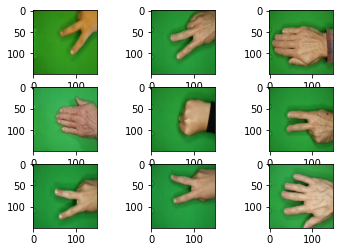

In [19]:
plot_images(train_generator)

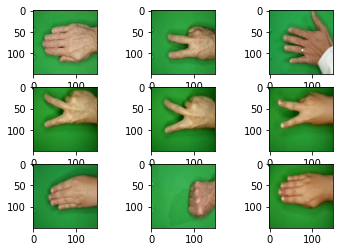

In [20]:
plot_images(test_generator)

In [21]:
X_train.shape

(1749, 150, 150, 3)

In [24]:
num_classes = 3

model = Sequential([
  layers.Conv2D(16, (3, 3), padding='same', input_shape=(ROWS, COLS, CHANNELS)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='sigmoid')
])

# def create_model():
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
# #     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
# #     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
# #     model.add(MaxPooling2D(pool_size=(2,2)))
# #     model.add(Conv2D(256, (3, 3), activation='relu'))
# #     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     # model.add(Dropout(0.5))

#     model.add(Flatten())
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation='relu'))
#     # model.add(Dense(1024, activation='relu'))
#     # model.add(Dense(1000, activation='relu'))
#     # model.add(Dropout(0.5))
#     model.add(Dense(3, activation='sigmoid'))
    
#     return model

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

In [27]:
epochs=10
history = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs
)


Epoch 1/10
14/14 [==============================] - 15s 901ms/step - loss: 1.3173 - accuracy: 0.3825 - val_loss: 0.9111 - val_accuracy: 0.6834
Epoch 2/10
14/14 [==============================] - 14s 1s/step - loss: 0.7256 - accuracy: 0.7410 - val_loss: 0.5327 - val_accuracy: 0.7904
Epoch 3/10
14/14 [==============================] - 16s 1s/step - loss: 0.4806 - accuracy: 0.8330 - val_loss: 0.3984 - val_accuracy: 0.8588
Epoch 4/10
14/14 [==============================] - 16s 1s/step - loss: 0.3286 - accuracy: 0.8942 - val_loss: 0.2672 - val_accuracy: 0.9157
Epoch 5/10
14/14 [==============================] - 15s 1s/step - loss: 0.2378 - accuracy: 0.9251 - val_loss: 0.1998 - val_accuracy: 0.9362
Epoch 6/10
14/14 [==============================] - 16s 1s/step - loss: 0.1291 - accuracy: 0.9646 - val_loss: 0.1346 - val_accuracy: 0.9431
Epoch 7/10
14/14 [==============================] - 15s 1s/step - loss: 0.0866 - accuracy: 0.9708 - val_loss: 0.1044 - val_accuracy: 0.9636
Epoch 8/10
14/14 

In [28]:
model.save('rock_paper_scissor.h5')

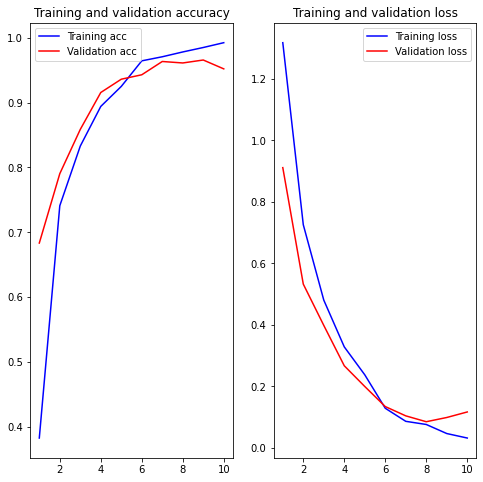

In [29]:
#acc = history.history['acc']
#val_acc = history.history['val_acc']
plt.figure(figsize=(8, 8))



loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
predictions = model.predict(X_test)


I am 57.61% sure this is a paper


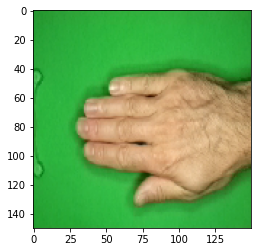

I am 57.61% sure this is a rock


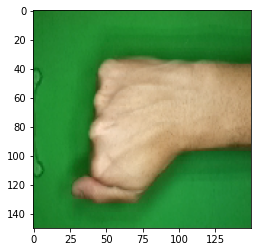

I am 57.61% sure this is a paper


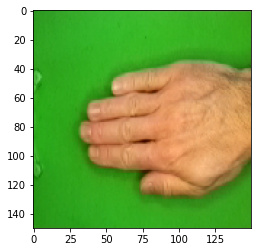

I am 57.61% sure this is a scissor


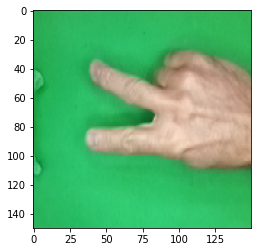

I am 57.61% sure this is a rock


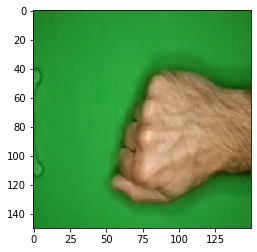

I am 57.61% sure this is a rock


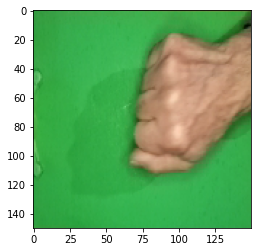

I am 57.61% sure this is a scissor


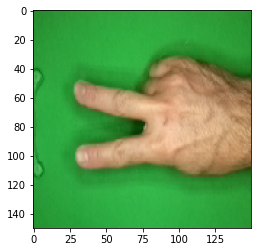

I am 57.61% sure this is a paper


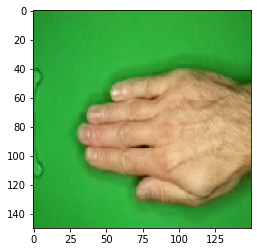

I am 57.61% sure this is a rock


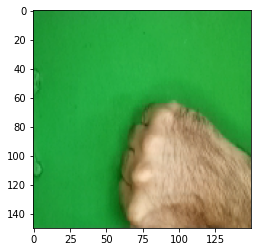

I am 57.61% sure this is a paper


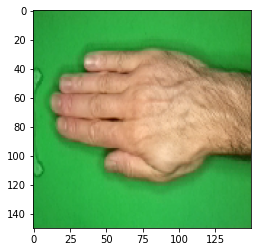

In [33]:
for i in range(0,10):
    score = tf.nn.softmax(predictions[i])
    if np.argmax(score) == 0:
        formato = "rock"
    elif np.argmax(score) == 1:
        formato = "scissor"
    else:
        formato = "paper"
        
    print('I am {:.2%} sure this is a {}'.format(np.max(score),formato))
    plt.imshow(image.array_to_img(X_test[i]))
    plt.show()


In [35]:
for i in predictions:
    score = tf.nn.softmax(i)
    print(np.max(score))

0.57611686
0.5761169
0.57611686
0.5761169
0.5761169
0.5761169
0.5761169
0.57611686
0.5761169
0.57611686
0.57611686
0.5739723
0.57611686
0.5761169
0.5761169
0.42231882
0.42231882
0.57611686
0.5761169
0.42231882
0.5761169
0.5761169
0.57611686
0.5761169
0.5761169
0.5761169
0.5761169
0.5761169
0.57611686
0.5761169
0.42231882
0.42231882
0.5761169
0.57611686
0.5761169
0.4595667
0.42231882
0.5761169
0.5761169
0.42231882
0.5761169
0.5761169
0.42231882
0.42231882
0.57611686
0.5761169
0.5761169
0.42231882
0.57611686
0.42231882
0.57611686
0.42231882
0.57611686
0.42231882
0.5761169
0.57611686
0.42231882
0.5761169
0.5761169
0.42231882
0.5761169
0.42231882
0.57611686
0.5761169
0.42231882
0.42231882
0.57611686
0.5761169
0.5761169
0.42231882
0.57611686
0.5761169
0.5761169
0.57611686
0.42231882
0.5761169
0.57611686
0.42231882
0.5761169
0.42231882
0.5761169
0.42231882
0.57611686
0.42231882
0.5761169
0.57611686
0.5761169
0.57611686
0.42231882
0.42231882
0.5761169
0.57611686
0.5761169
0.5761169
0.42231882